In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



# PINN for coupled Differential Equations

(Example problem taken from [https://math.libretexts.org/Bookshelves/Differential_Equations/Differential_Equations_(Chasnov)/07%3A_Systems_of_Equations/7.02%3A_Coupled_First-Order_Equations](https://math.libretexts.org/Bookshelves/Differential_Equations/Differential_Equations_(Chasnov)/07%3A_Systems_of_Equations/7.02%3A_Coupled_First-Order_Equations))

PINN to solve the following coupled differential equation

$$
\frac{dx_1(t)}{dt} = -\frac{1}{2}x_1(t) + x_2(t) 
$$

$$
\frac{dx_2(t)}{dt}= -x_1 - \frac{1}{2}x_2(t)
$$

In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = []
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output

### Loss function as a function of the initial conditions

In [3]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 10000 #how many times the training step is performed
BATCH_SIZE = 50 # how many input values are considered for each epoch
LEARNING_RATE = 5e-3 #learning rate
TOLERANCE = 1e-4 # error tolerance
NUM_INPUTS = 1

T_DOMAIN = (0.0, 20.0)
X1_DOMAIN = (-2.0, 2.0)
X2_DOMAIN = (-2.0, 2.0)

def loss_fun(
        X1: tf.keras.Model, 
        X2: tf.keras.Model,
        t: tf.Tensor,
        x1_0: float, # Init value of x1, i.e. x1(0)
        x2_0: float, # Init value of x2, i.e. x2(0)
)-> tf.Tensor:

    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(t)
        x1_val = X1(t)
        x2_val = X2(t)

    dx1_dt = tape.gradient(x1_val, t)
    dx2_dt = tape.gradient(x2_val, t)

    del tape

    de1 = dx1_dt + (1/2)*x1_val - x2_val
    de2 = dx2_dt + x1_val + (1/2)*x2_val

    b_x1 = X1(tf.convert_to_tensor([0.0])) - tf.convert_to_tensor([x1_0])
    b_x2 = X2(tf.convert_to_tensor([0.0])) - tf.convert_to_tensor([x2_0])

    loss_val = tf.reduce_mean(tf.square(de1) + tf.square(de2) + tf.square([b_x1]) + tf.square([b_x2]))

    return loss_val 

In [4]:
from IPython.display import clear_output

def train( # train the model for a given initial conditions and returns the predictions of the model
        x_0: tuple[float]
    ) -> tuple[tf.Tensor, tf.Tensor]:

    clear_output(wait=True)

    (x1_0, x2_0) = x_0 # initial boundary conditions
    print(x_0)
    X1 = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
    X2 = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
    optimizer_x1 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    optimizer_x2 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    @tf.function
    def train_step(x1, x2, input, x1_0, x2_0): # function for one single training step
        with tf.GradientTape(persistent=True) as tape:
            loss = loss_fun(x1, x2, input, x1_0, x2_0)

        gradients_x1 = tape.gradient(loss, x1.trainable_variables) # calculate the gradients of the loss with respect to \theta
        gradients_x2 = tape.gradient(loss, x2.trainable_variables) # calculate the gradients of the loss with respect to \theta
        optimizer_x1.apply_gradients(zip(gradients_x1, x1.trainable_variables)) # optimize the parameters to minimize the loss
        optimizer_x2.apply_gradients(zip(gradients_x2, x2.trainable_variables)) # optimize the parameters to minimize the loss

        del tape

        return loss
    
    for epoch in range(EPOCHS):
        input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=T_DOMAIN[0], maxval=T_DOMAIN[1], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
        loss = train_step(X1, X2, input_batch, x1_0, x2_0) # run the train step for the given batch
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')
        if loss <= TOLERANCE:
            print(f'Converged at epoch {epoch}')
            break

    t = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], 500)[:, tf.newaxis]
    
    x1_pred = X1(t)
    x2_pred = X2(t)

    return (x1_pred, x2_pred)



(1.0, 2.0)
Epoch: 0, Loss: 5.330346584320068
Epoch: 10, Loss: 1.9264135360717773
Epoch: 20, Loss: 0.29300153255462646
Epoch: 30, Loss: 0.3160431385040283
Epoch: 40, Loss: 0.12416109442710876
Epoch: 50, Loss: 0.07271821796894073
Epoch: 60, Loss: 0.03100975602865219
Epoch: 70, Loss: 0.0647861659526825
Epoch: 80, Loss: 0.04767334833741188
Epoch: 90, Loss: 0.03217434510588646
Epoch: 100, Loss: 0.015060734935104847
Epoch: 110, Loss: 0.026322081685066223
Epoch: 120, Loss: 0.029840560629963875
Epoch: 130, Loss: 0.011099508963525295
Epoch: 140, Loss: 0.021028919145464897
Epoch: 150, Loss: 0.01255456730723381
Epoch: 160, Loss: 0.010911697521805763
Epoch: 170, Loss: 0.009083106182515621
Epoch: 180, Loss: 0.010320425033569336
Epoch: 190, Loss: 0.016645317897200584
Epoch: 200, Loss: 0.01770877093076706
Epoch: 210, Loss: 0.01607120968401432
Epoch: 220, Loss: 0.015521032735705376
Epoch: 230, Loss: 0.010144290514290333
Epoch: 240, Loss: 0.012447240762412548
Epoch: 250, Loss: 0.007369348779320717
Epoc

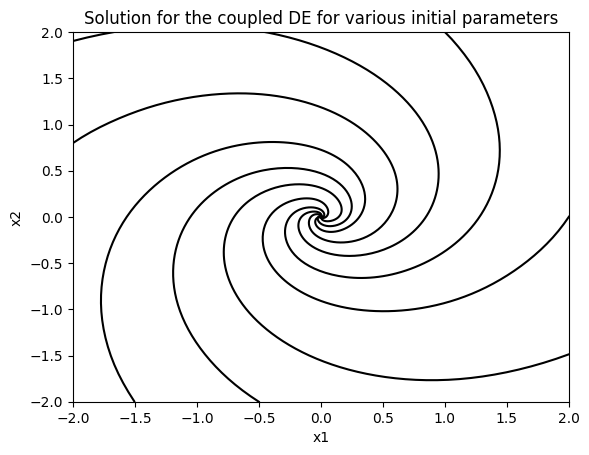

In [5]:
inits = [(2.0, 0.0), (2.0, -1.5), (-0.5, -2.0), (-1.5, -2.0), (-2.0, 0.8), (-2.0, 1.9), (1.0, 2.0)]

for init in inits:
    x1_pred, x2_pred = train(init)
    plt.plot(x1_pred, x2_pred, color='black')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Solution for the coupled DE for various initial parameters")
plt.show()

## Analytical solution

(from the above given link)

![Analytical solution](coupled_analytical.png)